# Week 5 Exercise

Let's start by importing the modules we need

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy import linalg


# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense


#Set default figure size
#mpl.rcParams['figure.figsize'] = [12.0, 8.0] #Inches... of course it is inches
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch

#Useful for debugging problems
print(tf.__version__)

2.6.0


### 1) Train a neural network on the MNIST training dataset that achieves acceptable performance on the test dataset (>95% accuracy)

Let's start by importing and normalising the MNIST dataset

In [4]:
mnist = keras.datasets.mnist   #The original handwritten digit MNIST
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# get pixel values from range [0,255] to range [0,1]
train_images=train_images/255.0
test_images=test_images/255.0

Let us now define our neural network model

In [5]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28,28)),   # shape of input values, i.e. shape of images (28x28 pixels)
    keras.layers.Dense(128,activation='relu'),   # 128 neurons in first hidden layer, with reLU as activation func.
    keras.layers.Dense(10)                       # 10 output neurons, each corresponding to a digit from 0 to 9
])

Now we will train the model to achieve an accuracy $>95\%$ on the MNIST dataset.

In [6]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=5, 
                    validation_data=(test_images, test_labels),steps_per_epoch=500)

Epoch 1/5
500/500 [==============================] - 2s 2ms/step - loss: 0.3609 - accuracy: 0.8999 - val_loss: 0.1928 - val_accuracy: 0.9452
Epoch 2/5
500/500 [==============================] - 1s 2ms/step - loss: 0.1619 - accuracy: 0.9537 - val_loss: 0.1391 - val_accuracy: 0.9584
Epoch 3/5
500/500 [==============================] - 1s 2ms/step - loss: 0.1169 - accuracy: 0.9664 - val_loss: 0.1048 - val_accuracy: 0.9688
Epoch 4/5
500/500 [==============================] - 1s 2ms/step - loss: 0.0902 - accuracy: 0.9739 - val_loss: 0.1000 - val_accuracy: 0.9706
Epoch 5/5
500/500 [==============================] - 1s 2ms/step - loss: 0.0741 - accuracy: 0.9783 - val_loss: 0.0840 - val_accuracy: 0.9755


In [8]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)  # test the neural network 
print(f'The model achieves an accuracy of {test_acc:0.3f} and a loss of {test_loss:0.3f}')

313/313 - 0s - loss: 0.0840 - accuracy: 0.9755
The model achieves an accuracy of 0.975 and a loss of 0.084


### 2) Decompose the MNIST training dataset into its PCA components

Now we will define the functions for singular value decomposition of the images, which is the equivalent of eigenvalue decomposition for rectangular matrices.

In [9]:
def get_vals_vecs(images):
    print("images.shape: ",np.shape(images))
    X=np.reshape(images,(len(images),784))
    print("X.shape:",np.shape(X))
    mu=np.mean(X,axis=0)
    x=X-mu
    #rho=np.dot(np.transpose(x),x)  #Make the covaraince matrix by hand
    rho=np.cov(x,rowvar=False) # Make the covaraince matrix by np.cov
    print("rho.shape:",np.shape(rho))

    #Get the eigenvalues and vectors
    vals,vecs=linalg.eigh(rho)
    #vals is a 1-D array of the eigenvalues in ascending order, vecs is a columnwise array of the normalised
    # eigenvectors such that vecs[:,i] is the eigenvector correspondong to vals[i]
    print("vecs.shape:",np.shape(vecs))
    print("vals.shape:",np.shape(vals))
    vecs=np.flip(vecs)
    vals=np.flip(vals)
    return mu,x,vecs,vals

We will also define a function which takes as input the eigenvectors of the MNIST dataset to compute the N best PCA components of every image.

In [10]:
def get_N_best_PCA(mu,x,vecs,images,N): 
    P=np.dot(x,vecs)
    PCA_components=(np.dot(P[:,0:N],vecs.T[0:N,:]))+mu
    new_images=np.reshape(PCA_components[:,:],[len(images),28,28])
    return new_images

Let us now plot the principal component of the first 6 images.

images.shape:  (60000, 28, 28)
X.shape: (60000, 784)
rho.shape: (784, 784)
vecs.shape: (784, 784)
vals.shape: (784,)


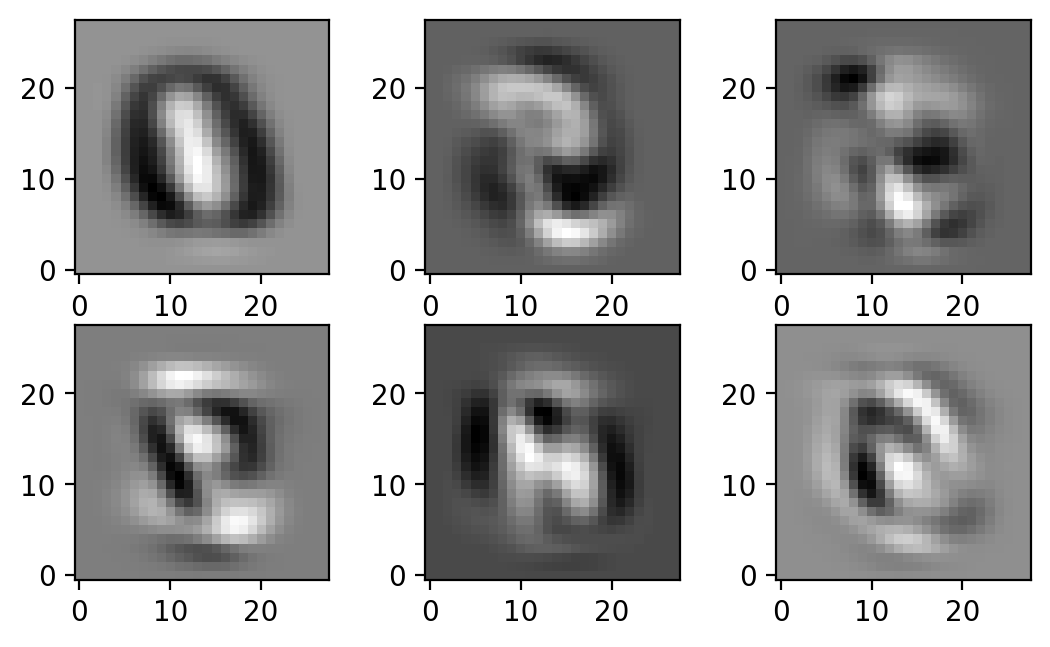

In [11]:
mu,x,vecs,vals=get_vals_vecs(train_images)


fig,ax=plt.subplots(2,3)
for i in range(2):
    for j in range(3):
        ax[i,j].imshow(np.reshape(vecs[:,(i+j*3)],[28,28]), origin='lower',cmap='binary',interpolation='nearest')
plt.subplots_adjust(left=0.05,
                    bottom=0.2, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.1, 
                    hspace=0.2)  #Adjust the space between the subplots so there isn't acres of whitespace

### 3) Use the N-best PCA components to make a new testing dataset (using the 10,000 MNIST test images) and make a plot of N vs testing accuracy using the neural network trained in 1) *WITOUT RETRAINING THE NETWORK*

Let us now calculate the N-best PCA components of the testing dataset images and test the accuracy of the neural network trained previously for different values of N.

In [18]:
mu,x,vecs,vals = get_vals_vecs(test_images)
N=[1,2,3,4,5,6,7,8,9,10,15,25,50,100,200,300,400,600,28*28]
acc_array1=[]

for n in N:
    new_test_images=get_N_best_PCA(mu,x,vecs,test_images,n) 
    test_loss, test_acc = model.evaluate(new_test_images,  test_labels, verbose=2)  # test the neural network 
    acc_array1.append(test_acc)

images.shape:  (10000, 28, 28)
X.shape: (10000, 784)
rho.shape: (784, 784)
vecs.shape: (784, 784)
vals.shape: (784,)
313/313 - 0s - loss: 4.5162 - accuracy: 0.1043
313/313 - 0s - loss: 3.5482 - accuracy: 0.1482
313/313 - 0s - loss: 3.1030 - accuracy: 0.2318
313/313 - 0s - loss: 2.6952 - accuracy: 0.2753
313/313 - 0s - loss: 2.6850 - accuracy: 0.2880
313/313 - 0s - loss: 2.0702 - accuracy: 0.4369
313/313 - 0s - loss: 1.8951 - accuracy: 0.4657
313/313 - 0s - loss: 1.5939 - accuracy: 0.5284
313/313 - 0s - loss: 1.2116 - accuracy: 0.6128
313/313 - 0s - loss: 1.1229 - accuracy: 0.6372
313/313 - 0s - loss: 0.5007 - accuracy: 0.8283
313/313 - 0s - loss: 0.2486 - accuracy: 0.9231
313/313 - 0s - loss: 0.1252 - accuracy: 0.9615
313/313 - 0s - loss: 0.0961 - accuracy: 0.9720
313/313 - 0s - loss: 0.0897 - accuracy: 0.9740
313/313 - 0s - loss: 0.0877 - accuracy: 0.9749
313/313 - 0s - loss: 0.0871 - accuracy: 0.9741
313/313 - 0s - loss: 0.0843 - accuracy: 0.9755
313/313 - 0s - loss: 0.0840 - accurac

Let's now plot the accuracy of the model against N.

Text(0.5, 0, 'N-best PCA components for test images')

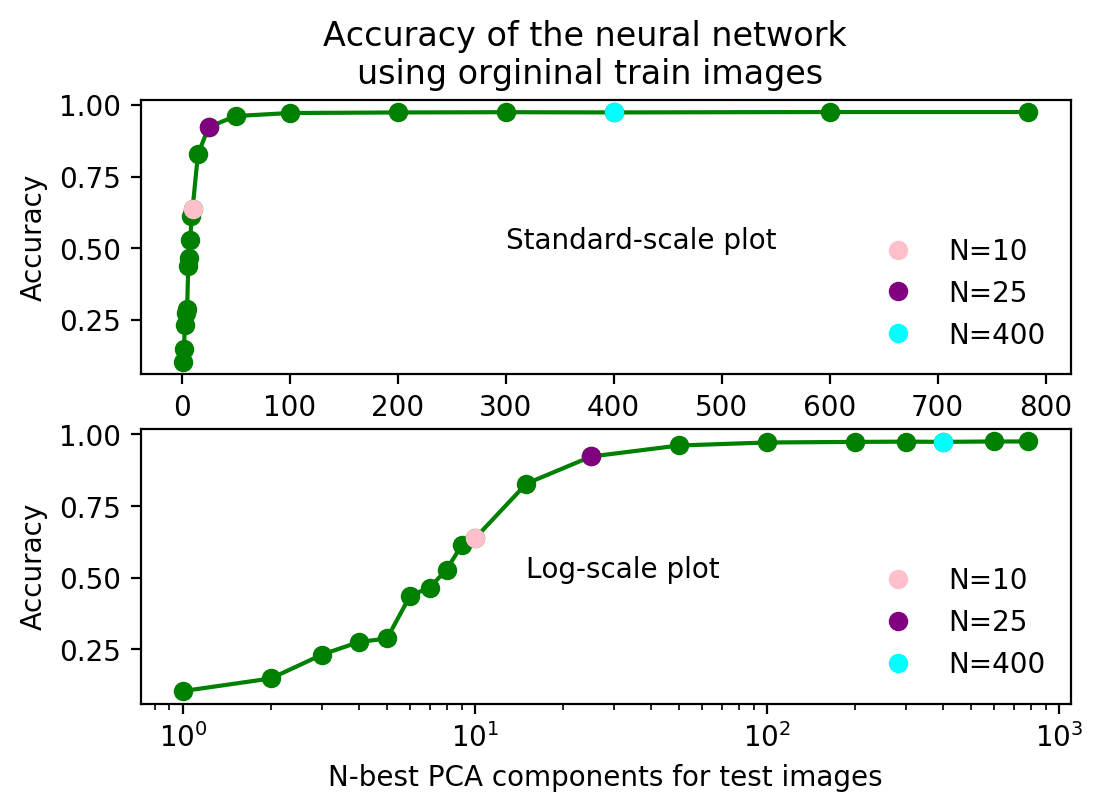

In [33]:
fig, axes = plt.subplots(2)
fig.suptitle("Accuracy of the neural network \nusing orgininal train images")   # plot the title

for ax in axes:
    ax.plot(N,acc_array1,'o-',color="green")   # plot accuracy datapoints
    ax.set_ylabel("Accuracy")                  # plot y axis label
    ax.plot(10,acc_array1[9],'o',color="pink",label='N=10')
    ax.plot(25,acc_array1[11],'o',color="purple",label='N=25')
    ax.plot(400,acc_array1[16],'o',color="aqua",label='N=400')


    ax.legend(loc='lower right')                                # add legend


    
axes[1].set_xscale('log')                      # change to log scale for subplot 2
axes[0].text(300,0.5,'Standard-scale plot')    # add text label inside graph
axes[1].text(15,0.5,'Log-scale plot')         # add text label inside graph
axes[1].set_xlabel("N-best PCA components for test images")                     # plot y axis label

As we can see from the plot above, the accuracy increases as we increase the N-best PCA components for the test images, and eventually reaches the maximum when we consider all 784 components. However we can see that the principal components is contributing to the overall accuracy more than any other component, as a matter of fact, as we increase N, the contribution of each single component to the overall accuracy decreases. 

Therefore we can conclude that our model learns more, and extracts more information, from the low N value components.

## 4) Now using the 100-best PCA components make a new training dataset (using the 60,000 MNIST training images) and retrain your neural network from 1)

Now we will re-initialise our model and calculate the 100-best PCA components for the training images

In [36]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28,28)),   # shape of input values, i.e. shape of images (28x28 pixels)
    keras.layers.Dense(128,activation='relu'),   # 128 neurons in first hidden layer, with reLU as activation func.
    keras.layers.Dense(10)                       # 10 output neurons, each corresponding to a digit from 0 to 9
])

In [37]:
mu,x,vecs,vals = get_vals_vecs(train_images)
new_train_images=get_N_best_PCA(mu,x,vecs,train_images,100) 

images.shape:  (60000, 28, 28)
X.shape: (60000, 784)
rho.shape: (784, 784)
vecs.shape: (784, 784)
vals.shape: (784,)


Let us now train our model and compute its accuracy.

In [38]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(new_train_images, train_labels, epochs=5, 
                    validation_data=(test_images, test_labels),steps_per_epoch=500)

Epoch 1/5
500/500 [==============================] - 1s 2ms/step - loss: 0.3614 - accuracy: 0.8990 - val_loss: 0.2038 - val_accuracy: 0.9420
Epoch 2/5
500/500 [==============================] - 1s 2ms/step - loss: 0.1652 - accuracy: 0.9525 - val_loss: 0.1441 - val_accuracy: 0.9583
Epoch 3/5
500/500 [==============================] - 1s 2ms/step - loss: 0.1197 - accuracy: 0.9657 - val_loss: 0.1082 - val_accuracy: 0.9690
Epoch 4/5
500/500 [==============================] - 1s 2ms/step - loss: 0.0940 - accuracy: 0.9723 - val_loss: 0.0987 - val_accuracy: 0.9710
Epoch 5/5
500/500 [==============================] - 1s 2ms/step - loss: 0.0788 - accuracy: 0.9769 - val_loss: 0.0905 - val_accuracy: 0.9726


In [39]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)  # test the neural network 
print(f'The model achieves an accuracy of {test_acc:0.3f} and a loss of {test_loss:0.3f}')

313/313 - 0s - loss: 0.0905 - accuracy: 0.9726
The model achieves an accuracy of 0.973 and a loss of 0.090


### 5) Repeat step 3 using your new neural network from 4)

Let us now calculate the N-best PCA components of the testing dataset images and test the accuracy of the neural network trained previously for different values of N.

In [40]:
mu,x,vecs,vals = get_vals_vecs(test_images)
N=[1,2,3,4,5,6,7,8,9,10,15,25,50,100,200,300,400,600,28*28]
acc_array2=[]

for n in N:
    new_test_images=get_N_best_PCA(mu,x,vecs,test_images,n) 
    test_loss, test_acc = model.evaluate(new_test_images,  test_labels, verbose=2)  # test the neural network 
    acc_array2.append(test_acc)

images.shape:  (10000, 28, 28)
X.shape: (10000, 784)
rho.shape: (784, 784)
vecs.shape: (784, 784)
vals.shape: (784,)
313/313 - 0s - loss: 3.9309 - accuracy: 0.1180
313/313 - 0s - loss: 2.9737 - accuracy: 0.1988
313/313 - 0s - loss: 2.6078 - accuracy: 0.2747
313/313 - 0s - loss: 2.2500 - accuracy: 0.3275
313/313 - 0s - loss: 2.1905 - accuracy: 0.3467
313/313 - 0s - loss: 1.5777 - accuracy: 0.5092
313/313 - 0s - loss: 1.4326 - accuracy: 0.5362
313/313 - 0s - loss: 1.2237 - accuracy: 0.6061
313/313 - 0s - loss: 0.9393 - accuracy: 0.6859
313/313 - 0s - loss: 0.8498 - accuracy: 0.7081
313/313 - 0s - loss: 0.4199 - accuracy: 0.8618
313/313 - 0s - loss: 0.2150 - accuracy: 0.9321
313/313 - 0s - loss: 0.1150 - accuracy: 0.9657
313/313 - 0s - loss: 0.0882 - accuracy: 0.9733
313/313 - 0s - loss: 0.0880 - accuracy: 0.9741
313/313 - 0s - loss: 0.0892 - accuracy: 0.9726
313/313 - 0s - loss: 0.0895 - accuracy: 0.9722
313/313 - 0s - loss: 0.0903 - accuracy: 0.9726
313/313 - 0s - loss: 0.0905 - accurac

Let's now plot the accuracy of the model against N.

Text(0.5, 0, 'N-best PCA components for test images')

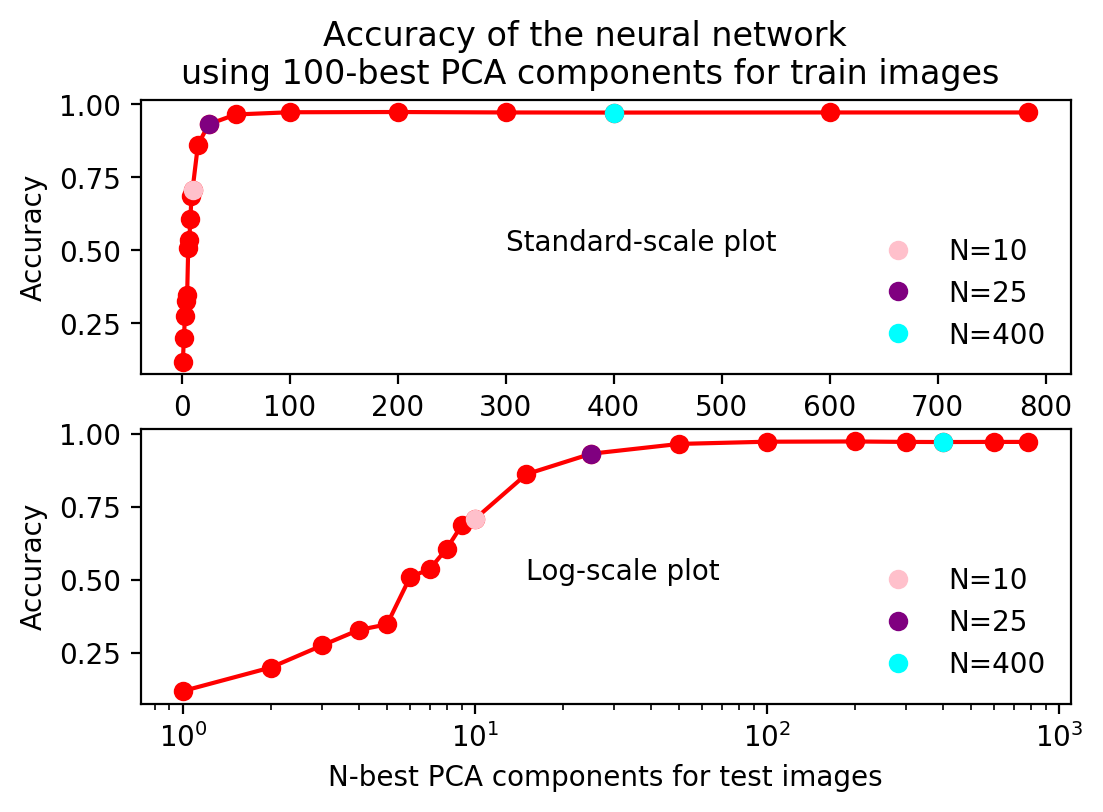

In [43]:
fig, axes = plt.subplots(2)
fig.suptitle("Accuracy of the neural network \nusing 100-best PCA components for train images")

for ax in axes:
    ax.plot(N,acc_array2,'o-',color="red")   # plot accuracy datapoints
    ax.set_ylabel("Accuracy")                  # plot y axis label
    ax.plot(10,acc_array2[9],'o',color="pink",label='N=10')
    ax.plot(25,acc_array2[11],'o',color="purple",label='N=25')
    ax.plot(400,acc_array2[16],'o',color="aqua",label='N=400')
    ax.legend(loc='lower right')                                # add legend

axes[1].set_xscale('log')                      # change to log scale for subplot 2
axes[0].text(300,0.5,'Standard-scale plot')    # add text label inside graph
axes[1].text(15,0.5,'Log-scale plot')         # add text label inside graph
axes[1].set_xlabel("N-best PCA components for test images")                     # plot y axis label

### 6) Finally repeat steps 4 and 5 using a network trained with the best 20 components

Now we will re-initialise our model and calculate the 20-best PCA components for the training images

In [44]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28,28)),   # shape of input values, i.e. shape of images (28x28 pixels)
    keras.layers.Dense(128,activation='relu'),   # 128 neurons in first hidden layer, with reLU as activation func.
    keras.layers.Dense(10)                       # 10 output neurons, each corresponding to a digit from 0 to 9
])

In [45]:
mu,x,vecs,vals = get_vals_vecs(train_images)
new_train_images=get_N_best_PCA(mu,x,vecs,train_images,20) 

images.shape:  (60000, 28, 28)
X.shape: (60000, 784)
rho.shape: (784, 784)
vecs.shape: (784, 784)
vals.shape: (784,)


Let us now train our model and compute its accuracy.

In [46]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(new_train_images, train_labels, epochs=5, 
                    validation_data=(test_images, test_labels),steps_per_epoch=500)

Epoch 1/5
500/500 [==============================] - 1s 2ms/step - loss: 0.4547 - accuracy: 0.8695 - val_loss: 0.3090 - val_accuracy: 0.9148
Epoch 2/5
500/500 [==============================] - 1s 2ms/step - loss: 0.2372 - accuracy: 0.9298 - val_loss: 0.2439 - val_accuracy: 0.9268
Epoch 3/5
500/500 [==============================] - 1s 2ms/step - loss: 0.1799 - accuracy: 0.9469 - val_loss: 0.1993 - val_accuracy: 0.9425
Epoch 4/5
500/500 [==============================] - 1s 2ms/step - loss: 0.1518 - accuracy: 0.9544 - val_loss: 0.1830 - val_accuracy: 0.9434
Epoch 5/5
500/500 [==============================] - 1s 2ms/step - loss: 0.1363 - accuracy: 0.9589 - val_loss: 0.1685 - val_accuracy: 0.9502


In [47]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)  # test the neural network 
print(f'The model achieves an accuracy of {test_acc:0.3f} and a loss of {test_loss:0.3f}')

313/313 - 0s - loss: 0.1685 - accuracy: 0.9502
The model achieves an accuracy of 0.950 and a loss of 0.169


Let us now calculate the N-best PCA components of the testing dataset images and test the accuracy of the neural network trained previously for different values of N.

In [51]:
mu,x,vecs,vals = get_vals_vecs(test_images)
N=[1,2,3,4,5,6,7,8,9,10,15,25,50,100,200,300,400,600,28*28]
acc_array3=[]

for n in N:
    new_test_images=get_N_best_PCA(mu,x,vecs,test_images,n) 
    test_loss, test_acc = model.evaluate(new_test_images,  test_labels, verbose=2)  # test the neural network 
    acc_array3.append(test_acc)

images.shape:  (10000, 28, 28)
X.shape: (10000, 784)
rho.shape: (784, 784)
vecs.shape: (784, 784)
vals.shape: (784,)
313/313 - 0s - loss: 4.5134 - accuracy: 0.0968
313/313 - 0s - loss: 3.6150 - accuracy: 0.1583
313/313 - 0s - loss: 3.1345 - accuracy: 0.2059
313/313 - 0s - loss: 2.6800 - accuracy: 0.2715
313/313 - 0s - loss: 2.6323 - accuracy: 0.2859
313/313 - 0s - loss: 1.8621 - accuracy: 0.4540
313/313 - 0s - loss: 1.5918 - accuracy: 0.4981
313/313 - 0s - loss: 1.2213 - accuracy: 0.5853
313/313 - 0s - loss: 0.8347 - accuracy: 0.6870
313/313 - 0s - loss: 0.7199 - accuracy: 0.7336
313/313 - 0s - loss: 0.2587 - accuracy: 0.9152
313/313 - 0s - loss: 0.1373 - accuracy: 0.9592
313/313 - 0s - loss: 0.1497 - accuracy: 0.9551
313/313 - 0s - loss: 0.1617 - accuracy: 0.9511
313/313 - 0s - loss: 0.1670 - accuracy: 0.9503
313/313 - 0s - loss: 0.1678 - accuracy: 0.9505
313/313 - 0s - loss: 0.1689 - accuracy: 0.9499
313/313 - 0s - loss: 0.1685 - accuracy: 0.9503
313/313 - 0s - loss: 0.1685 - accurac

Let's now plot the accuracy of the model against N.

Text(0.5, 0, 'N-best PCA components for test images')

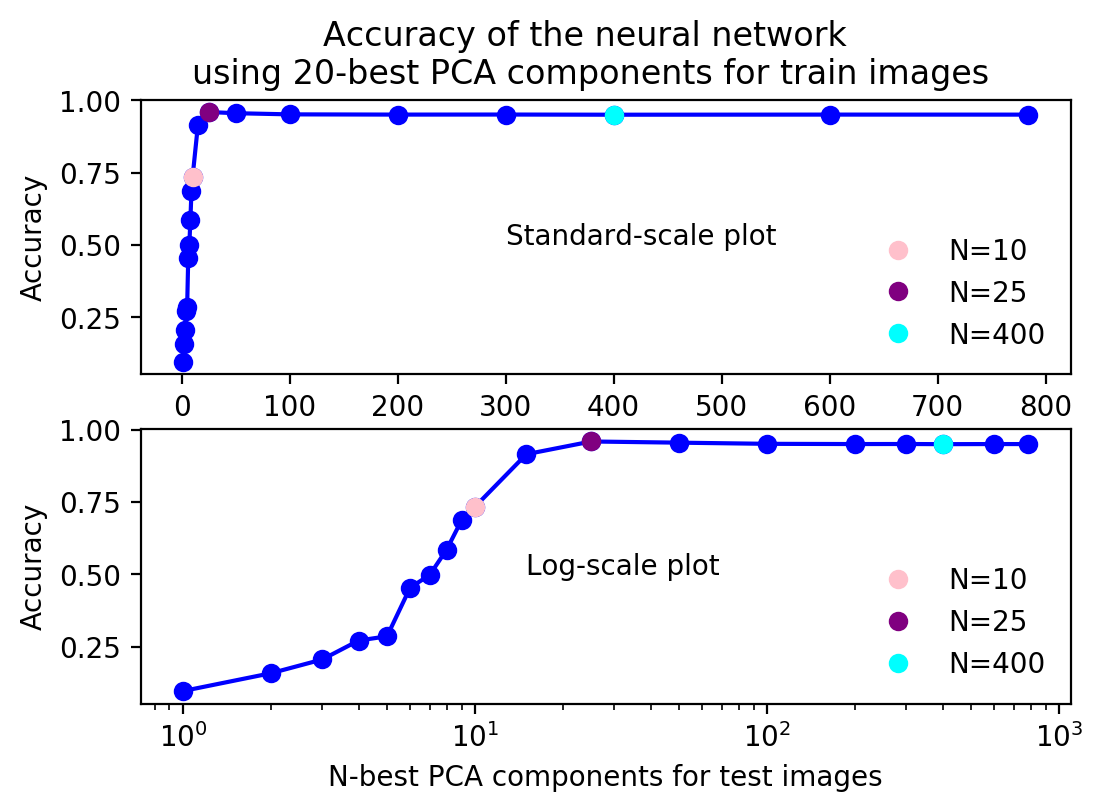

In [53]:
fig, axes = plt.subplots(2)
fig.suptitle("Accuracy of the neural network \nusing 20-best PCA components for train images")

for ax in axes:
    ax.plot(N,acc_array3,'o-',color="blue")   # plot accuracy datapoints
    ax.set_ylabel("Accuracy")                  # plot y axis label
    ax.plot(10,acc_array3[9],'o',color="pink",label='N=10')
    ax.plot(25,acc_array3[11],'o',color="purple",label='N=25')
    ax.plot(400,acc_array3[16],'o',color="aqua",label='N=400')
    ax.legend(loc='lower right')                                # add legend

axes[1].set_xscale('log')                      # change to log scale for subplot 2
axes[0].text(300,0.5,'Standard-scale plot')    # add text label inside graph
axes[1].text(15,0.5,'Log-scale plot')         # add text label inside graph
axes[1].set_xlabel("N-best PCA components for test images")                     # plot y axis label

Text(0.5, 0, 'N-best PCA components for test images')

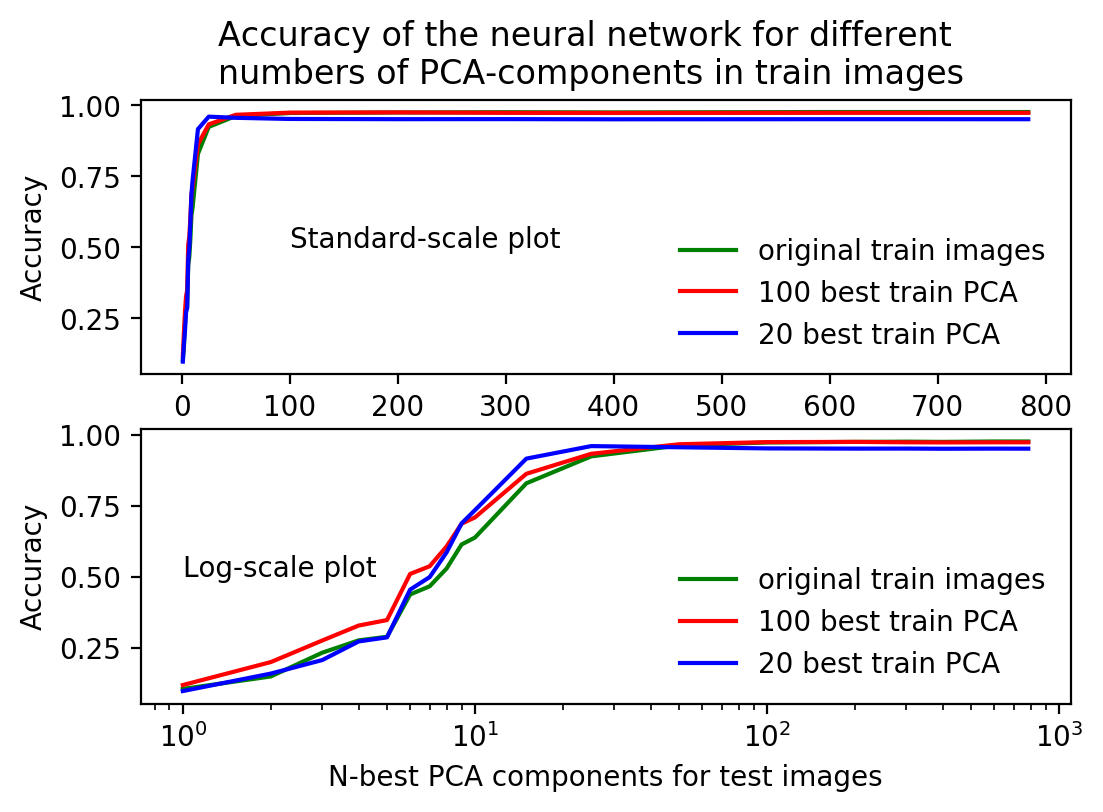

In [59]:
fig, axes = plt.subplots(2)
fig.suptitle("Accuracy of the neural network for different \nnumbers of PCA-components in train images")

color=["green","red","blue"]
acc_array=[acc_array1,acc_array2,acc_array3]
labels=['original train images','100 best train PCA','20 best train PCA']
i=0
for ax in axes:
    for i in range(3):
        ax.plot(N,acc_array[i],'-',color=color[i],label=labels[i])
        ax.set_ylabel("Accuracy")
        ax.legend()

    
axes[1].set_xscale('log')
axes[0].text(100,0.5,'Standard-scale plot')    # add text label inside graph
axes[1].text(1,0.5,'Log-scale plot')         # add text label inside graph
axes[1].set_xlabel("N-best PCA components for test images")

Firstly we can notice that in all the 3 analysed cases the accuracy increases very quickly for low values of N and then has an asymptotic behaviour, meaning that an increasing N-best PCA components in test images does not significantly improve the accuracy anymore.

As we can see from the plots above the number of N-best components used to train the model affect both the maximum accuracy of the model and the level at with which the model achieves the max accuracy.

- The maximum accuracy using the **original dataset** for training, achieved at $N_{test}=784$, is: $a_{max}=0.9755$.
- The maximum accuracy using the **100-best PCA components** for training, achieved at $N_{test}=100$, is: $a_{max}=0.9741$.
- The maximum accuracy using the **20-best PCA components** for training, achieved at $N_{test}=20$, is: $a_{max}=0.9592$.

As expected the maximum accuracy of the model decreases as we decrease the N-best components used to train the model. Also we can note that the maximum accuracy of the model is achieved when it is tested on the same number of PCA components it was trained on, i.e. when $N_{train}=N_{test}$. This is because the model is "used" to deal with $N_{train}$ components and hence will give its maximum performance when it is tested on that same number of components.

Furthermore we can notice that the even though we significantly decrease the number of best $N_{train}$ PCA components from the original $784$ to $20$, the accuracy of the model decreases by only $1.6\%$. A lower number of best $N_{train}$ PCA components therefore does not significantly affect the accuracy of the model, while increasing it efficiency, since it decreases the amount of training data fed to the model.

Also since the the maximum accuracy using the **20-best PCA components** for training is achieved at $N_{test}=20$, the model is also more consistent, as it achieves an accuracy $>95\%$ on a wider range of $N_{test}$ as compared to the other models with higher $N_{train}$. 